In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy.stats import entropy
import networkit as nk #more efficient
import pickle
import statistics

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'visual','3Dspace')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [4]:
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_'

In [5]:
#with weight on the edge: TODO AND READ
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

In [6]:
#choose mvt
#choose mvt var to keep
#not: vertical_travel_distance_perinsideh, as we think its how much oyu actuallly can do this
#nestboxes: later but longer
li_mvt = ['mid_cum_Z4_h_Morning','WentinWG','Total_number_transition','nbr_stays_1_Zone','vertical_travel_distance',
         'duration_1_Zone_min','duration_2_Zone_min','duration_3_Zone_min','duration_4_Zone_min','duration_5_Zone_min']

# Experiment 2 - HA & 7 days previous HA

In [7]:
df_exp2mvt = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', parse_dates=['level'],
                dayfirst=True) 
df_h = df_exp2mvt.groupby('HenID')['CorrectPenID'].agg(lambda x: list(set(x))).reset_index()
df_h['nbrR'] = df_h['CorrectPenID'].map(lambda x: len(x))
display(df_h['nbrR'].value_counts())
df_h['Relocated'] = df_h['nbrR'].map(lambda x: x!=1)
display(df_h.head(3))
dico_henid_isrel = dict(zip(df_h['HenID'].tolist(), df_h['Relocated'].tolist()))
#dico_henid_isrel
df_exp2mvt['Is_relocated'] = df_exp2mvt['HenID'].map(lambda x: dico_henid_isrel[x])
display(df_exp2mvt['Is_relocated'].value_counts())
dico_R_date = {'R1':dt.datetime(2021,11,30), 'R2':dt.datetime(2022,2,8), 'R3':dt.datetime(2022,4,12),
               'late':dt.datetime(2022,7,5)}
df_exp2mvt['is_after'] = df_exp2mvt.apply(lambda x: x['level']>dico_R_date.get(x['Period_type'],dt.datetime(2020,1,1)), 
                                                  axis=1)
df_ = df_exp2mvt.groupby(['Period_type','is_after'])['level'].agg(lambda x: [str(i).split(' ')[0] for i in set(x)]).reset_index()
df_['nbr_days'] = df_['level'].map(lambda x: len(x))

#keep only before HA days, avoid mixinf effect of these HA stress on movmenets
print(df_exp2mvt.shape)
df_exp2mvt = df_exp2mvt[~df_exp2mvt['is_after']].copy()
#add habituation time
df_exp2mvt['time2event'] = df_exp2mvt.apply(lambda x: (dico_R_date[x['Period_type']]-x['level']).days, axis=1)
display(df_exp2mvt['time2event'].value_counts())
print(df_exp2mvt.shape)

display(df_)
print(df_exp2mvt.shape)
df_exp2mvt.head(3)

1    85
4    78
2     3
3     3
Name: nbrR, dtype: int64

,HenID,CorrectPenID,nbrR,Relocated
0,hen_1,"[pen9, pen10, pen11, pen8]",4,True
1,hen_10,"[pen3, pen9, pen10, pen11]",4,True
2,hen_100,"[pen12, pen9, pen8, pen4]",4,True


False    3859
True     3738
Name: Is_relocated, dtype: int64

(7597, 46)


7    655
4    654
5    653
6    652
3    612
1    611
2    609
Name: time2event, dtype: int64

(4446, 47)


,Period_type,is_after,level,nbr_days
0,R1,False,"[2021-11-29, 2021-11-23, 2021-11-27, 2021-11-2...",7
1,R1,True,[2021-12-01],1
2,R2,False,"[2022-02-06, 2022-02-07, 2022-02-03, 2022-02-0...",7
3,R2,True,"[2022-02-15, 2022-02-09, 2022-02-12, 2022-02-1...",8
4,R3,False,"[2022-04-08, 2022-04-11, 2022-04-10, 2022-04-0...",7
5,R3,True,"[2022-04-19, 2022-04-14, 2022-04-16, 2022-04-1...",8
6,early,True,"[2021-10-10, 2021-10-17, 2021-10-18, 2021-10-1...",5
7,late,False,"[2022-07-02, 2022-06-29, 2022-07-01, 2022-07-0...",7


(4446, 47)


,HenID,level,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_zone,mid_cum_Z4_sec,Total_number_transition,vertical_travel_distance,...,CorrectPenID,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,Is_relocated,is_after,time2event
807,hen_1,2021-11-23,25.0,66.0,7.0,2.0,4.0,8516.0,43.0,43.0,...,pen10,0.0,535.966667,201.916667,55.800000,16.316667,False,True,False,7
808,hen_1,2021-11-24,21.0,51.0,7.0,21.0,4.0,8126.0,45.0,48.0,...,pen10,0.0,410.600000,171.883333,53.783333,173.733333,False,True,False,6
809,hen_1,2021-11-25,27.0,59.0,7.0,7.0,4.0,7837.0,62.0,62.0,...,pen10,0.0,478.016667,220.283333,56.600000,55.100000,False,True,False,5


### add HA

In [8]:
path_KBF = r'G:\VPHI\Welfare\2- Research Projects\Camille Montalcini\Origins.GS\DataOutput\HA'
df_KBF = pd.read_csv(os.path.join(path_KBF, 'df_KBF.csv'), sep=',') 
df_KBF = df_KBF.rename(columns={'has_gap':'gap'})
#remove observation on empty pictures (typically wrong radiograph)
df_KBF = df_KBF[~df_KBF['HenIDKBF_withtagid'].isnull()]
#remove nn focal birds for now
df_KBF['is_NonFocal'] = df_KBF['HenIDKBF_withtagid'].map(lambda x: 'rpen' in x.lower())
df_KBF = df_KBF[~df_KBF['is_NonFocal']]
#now we can remove 'pen'
df_KBF['HenIDKBF_withtagid'] = df_KBF['HenIDKBF_withtagid'].map(lambda x: x.replace('pen','').replace('daarkblue','darkblue'))
df_KBF['HenIDKBF'] = df_KBF['HenIDKBF_withtagid'].copy()
#HenIDKBF now contains elements of HenIDKBF_withtagid where tagidmatch is empty, and elements from tagidmatch when it snot empty
df_KBF['HenIDKBF'] = np.where(df_KBF['tagidmatch'].isnull(), df_KBF['HenIDKBF'], df_KBF['tagidmatch'])
#small check
display(df_KBF[~df_KBF['tagidmatch'].isnull()][['HenIDKBF_withtagid','HenIDKBF','tagidmatch']].head(3))
#make sure all green is brightgreen
df_KBF['HenIDKBF'] = df_KBF['HenIDKBF'].map(lambda x: x.replace('brightgreen','green'))
df_KBF['HenIDKBF'] = df_KBF['HenIDKBF'].map(lambda x: x.replace('green','brightgreen'))
#extract color ame by removing all numbers from the string (are either only at the end or at begining and end)
df_KBF['LPLegring'] = df_KBF['HenIDKBF'].map(lambda x: re.sub(r"\d+", "", str(x))) 
#split with the color and keep last entry: the legring number
df_KBF['legringID'] = df_KBF['HenIDKBF'].map(lambda x: x.split(re.sub(r"\d+", "", str(x)))[-1])
df_KBF['FocalLegringName'] = df_KBF.apply(lambda x: x['LPLegring']+x['legringID'], axis=1)
#split with the color and keep first entry: the penID when exist
df_KBF['PenID'] = df_KBF['HenIDKBF'].map(lambda x: x.split(re.sub(r"\d+", "", str(x)))[0])
#multiply to amtch scale of exp1
df_KBF['severity'] = df_KBF['severity'].map(lambda x: 10*x)
display(df_KBF['LPLegring'].value_counts())
print(df_KBF.shape)
display(df_KBF.head(3))

,HenIDKBF_withtagid,HenIDKBF,tagidmatch
3,12tagid152pink,pink27,pink27
7,12pinktagid152,pink27,pink27
13,3tagid119yellow,yellow7,yellow7


brightgreen    91
darkblue       86
lightblue      84
black          84
red            83
yellow         82
violette       81
pink           78
Name: LPLegring, dtype: int64

(669, 16)


,initial_path_img,actual_path_img,imageID,HAID,random_order1,HenIDKBF_withtagid,tagidmatch,gap,severity,comment,is_NonFocal,HenIDKBF,LPLegring,legringID,FocalLegringName,PenID
0,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,0,HA2,330,12pink58,NaN,0.0,6.0,NaN,False,12pink58,pink,58,pink58,12
1,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,1,HA3,77,10red49,NaN,1.0,24.0,NaN,False,10red49,red,49,red49,10
2,G:\VPHI\Welfare\2- Research Projects\Camille M...,G:\VPHI\Welfare\2- Research Projects\Camille M...,2,HA1,50,lightblue39,NaN,0.0,0.0,NaN,False,lightblue39,lightblue,39,lightblue39,


In [9]:
#at the hen level
df_KBFhen = df_KBF.pivot(index='FocalLegringName', columns='HAID', values='severity').reset_index()
df_KBFhen = df_KBFhen.rename(columns={'HA1':'HA1_severity', 'HA2':'HA2_severity', 'HA3':'HA3_severity', 'HA4':'HA4_severity'})
df_gaphen = df_KBF.pivot(index='FocalLegringName', columns='HAID', values='gap').reset_index()
df_gaphen = df_gaphen.rename(columns={'HA1':'HA1_gap', 'HA2':'HA2_gap', 'HA3':'HA3_gap', 'HA4':'HA4_gap'})
df_KBFhen = pd.merge(df_KBFhen, df_gaphen, on='FocalLegringName')
print(df_KBFhen.shape)
display(df_KBFhen.head(3))

(172, 9)


HAID,FocalLegringName,HA1_severity,HA2_severity,HA3_severity,HA4_severity,HA1_gap,HA2_gap,HA3_gap,HA4_gap
0,black1,0.0,1.0,5.0,7.0,0.0,0.0,0.0,0.0
1,black10,0.0,19.0,0.0,30.0,0.0,1.0,0.0,1.0
2,black11,0.0,2.0,12.0,12.0,0.0,0.0,0.0,0.0


In [10]:
#merge on unique HenID:  FocalLegringName
df_FB = pd.read_csv(os.path.join(path_KBF, 'Focalbirds_12-07-2022.csv'), encoding='latin',sep=',') 
print(df_FB.shape)
print(df_FB.columns)
#only one legring color per initialPenID
display(df_FB.groupby(['PenID','LPLegring'])['FocalLegringName'].count().reset_index())
display(df_FB.head(3))
print(len(df_FB['FocalLegringName'].unique()), df_FB.shape[0])
df_HAexp2 = pd.merge(df_FB, df_KBFhen, on='FocalLegringName', how='left') #outer: is three more rows, but with many nan and I cant match it back
print(df_FB.shape, df_KBFhen.shape, df_HAexp2.shape)
df_HAexp2['HenID'] = df_HAexp2['HenID'].map(lambda x: 'hen_'+str(int(x)))
#add total feathers
for i in [1,2,3,4]:
    #lead to nan if any numebr is nan
    df_HAexp2['HA'+str(i)+'_FeatherDamage'] = df_HAexp2.apply(lambda x: 100-np.mean([x['HA'+str(i)+'_BreastFeather'],
                                                                    x['HA'+str(i)+'_TailFeather'],
                                                                    x['HA'+str(i)+'_NeckFeather']]), axis=1)
#four early death, missing HA4 for these ones
display(df_HAexp2[df_HAexp2['early death']==1])
df_HAexp2.rename(columns={'early death':'early_death'}, inplace=True)
df_HAexp2['early_death'].fillna(0, inplace=True)
display(df_HAexp2['early_death'].value_counts())
#save
df_HAexp2.to_csv(os.path.join(path_extracted_data,id_run+'_df_HAexp2_ALL.csv'), sep=',', index=False)
display(df_HAexp2.head(3))

(169, 47)
Index(['HenID', 'SireID', 'RPenID', 'PenID', 'Rtreatment', 'LPLegring',
       'legringID', 'FocalLegringName', 'HA1_weight', 'HA1_NeckFeather',
       'HA1_BreastFeather', 'HA1_TailFeather', 'HA1_Leg right', 'HA1_Leg left',
       'Nail missing', 'commentSelection', 'weight-08-10-2021', 'BackpackID',
       'TagID', 'commentPopulation', 'early death', 'comment HA',
       'InitialStartDate', 'StartDate', 'EndDate', 'ShouldBeExcluded',
       'exception', 'R1', 'R2', 'R3', 'HA2_weight', 'HA2_NeckFeather',
       'HA2_BreastFeather', 'HA2_TailFeather', 'HA2_Leg right', 'HA2_Leg left',
       'HA2_NailMissing', 'HA3_weight', 'HA3_NeckFeather', 'HA3_BreastFeather',
       'HA3_TailFeather', 'comment HA3 12-04-2022', 'HA4_weight',
       'HA4_NeckFeather', 'HA4_BreastFeather', 'HA4_TailFeather',
       'comment HA4 05-07-2022'],
      dtype='object')


,PenID,LPLegring,FocalLegringName
0,pen10,red,21
1,pen11,lightblue,21
2,pen12,pink,20
3,pen3,yellow,21
4,pen4,brightgreen,23
5,pen5,black,21
6,pen8,darkblue,21
7,pen9,violette,21


,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,HA1_weight,HA1_NeckFeather,...,HA3_weight,HA3_NeckFeather,HA3_BreastFeather,HA3_TailFeather,comment HA3 12-04-2022,HA4_weight,HA4_NeckFeather,HA4_BreastFeather,HA4_TailFeather,comment HA4 05-07-2022
0,13,47,Rpen12,pen10,Queue,red,5,red5,1704.1,100,...,1755.4,92,63,74,NaN,1759.0,60.0,67.0,71.0,NaN
1,12,6,Rpen13,pen10,NoQueue,red,8,red8,1646.9,100,...,1700.1,55,62,75,NaN,1694.9,55.0,45.0,61.0,NaN
2,8,77,Rpen12,pen10,Queue,red,9,red9,1816.3,100,...,1889.7,53,44,93,NaN,1823.0,52.0,47.0,72.0,NaN


169 169
(169, 47) (172, 9) (169, 55)


,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,HA1_weight,HA1_NeckFeather,...,HA3_severity,HA4_severity,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage
49,hen_48,3,Rpen13,pen12,NoQueue,pink,30,pink30,1739.8,100,...,19.0,NaN,0.0,0.0,0.0,NaN,0.000000,1.666667,2.000000,NaN
90,hen_96,44,Rpen11,pen4,Queue,brightgreen,10,brightgreen10,1723.8,100,...,11.0,NaN,1.0,0.0,0.0,NaN,2.333333,37.000000,20.333333,NaN
130,hen_3,78,Rpen13,pen10,NoQueue,red,15,red15,1779.6,100,...,21.0,NaN,1.0,1.0,0.0,NaN,2.666667,15.666667,28.000000,NaN
163,hen_163,85,Rpen11,pen9,Queue,violette,18,violette18,1699.3,100,...,4.0,NaN,0.0,0.0,0.0,NaN,0.000000,19.333333,34.333333,NaN


0.0    165
1.0      4
Name: early_death, dtype: int64

,HenID,SireID,RPenID,PenID,Rtreatment,LPLegring,legringID,FocalLegringName,HA1_weight,HA1_NeckFeather,...,HA3_severity,HA4_severity,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage
0,hen_13,47,Rpen12,pen10,Queue,red,5,red5,1704.1,100,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.666667,23.666667,34.000000
1,hen_12,6,Rpen13,pen10,NoQueue,red,8,red8,1646.9,100,...,18.0,25.0,0.0,0.0,1.0,1.0,0.0,25.333333,36.000000,46.333333
2,hen_8,77,Rpen12,pen10,Queue,red,9,red9,1816.3,100,...,27.0,30.0,0.0,1.0,0.0,0.0,0.0,18.000000,36.666667,43.000000


In [11]:
# add HA in dataframe for latent score models
#dropping initialpenid column to avoid confusion with correctpenid = pen where the naiml is (due to relocation it is confusing)
df_HAexp2.drop(['PenID'], axis=1, inplace=True)
df_exp2 = pd.merge(df_exp2mvt, df_HAexp2, on='HenID', how='left')
print(df_exp2mvt.shape, df_HAexp2.shape, df_exp2.shape)
df_exp2['Treatment'] = df_exp2['Is_relocated'].map(lambda x: 'IsRelocated' if x else 'IsNotRelocated')
df_exp2['Is2Experiment'] = 1
display(df_exp2.head(3))

(4446, 47) (169, 58) (4446, 104)


,HenID,level,perc_duration_3_Zone,perc_duration_2_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_zone,mid_cum_Z4_sec,Total_number_transition,vertical_travel_distance,...,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage,Treatment,Is2Experiment
0,hen_1,2021-11-23,25.0,66.0,7.0,2.0,4.0,8516.0,43.0,43.0,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,IsRelocated,1
1,hen_1,2021-11-24,21.0,51.0,7.0,21.0,4.0,8126.0,45.0,48.0,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,IsRelocated,1
2,hen_1,2021-11-25,27.0,59.0,7.0,7.0,4.0,7837.0,62.0,62.0,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,IsRelocated,1


In [12]:
df_exp2.rename(columns={'CorrectPenID':'PenID'}, inplace=True)
li_save = ['DOA','Period_type','PenID','Is_relocated','time2event','level','early_death',
          'HenID', 'RPenID', 'Rtreatment','Is2Experiment','Treatment']+li_mvt+[i for i in df_exp2.columns if 'HA' in i]
df_exp2['HenID'] = df_exp2['HenID'].map(lambda x: 'EXP2_'+x)
df_exp2 = df_exp2[li_save]
df_exp2['ExperimentID'] = 'Exp2'
df_exp2['daytimeduration'] = df_exp2['level'].map(lambda x: 14 if x>=dt.datetime(2021,11,26) else 13.5)
print(df_exp2['daytimeduration'].value_counts())
print(df_exp2.groupby('daytimeduration')['level'].agg(lambda x: len(set(x))))
display(df_exp2.head(3))
print(df_exp2.shape)

14.0    3954
13.5     492
Name: daytimeduration, dtype: int64
daytimeduration
13.5     3
14.0    25
Name: level, dtype: int64


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Rtreatment,...,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage,ExperimentID,daytimeduration
0,167,R1,pen10,True,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,Queue,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,Exp2,13.5
1,168,R1,pen10,True,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,Queue,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,Exp2,13.5
2,169,R1,pen10,True,5,2021-11-25,0.0,EXP2_hen_1,Rpen12,Queue,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,Exp2,13.5


(4446, 60)


In [13]:
df_exp2[['level','time2event','Period_type']].head(3)

,level,time2event,Period_type
0,2021-11-23,7,R1
1,2021-11-24,6,R1
2,2021-11-25,5,R1


# Experiment 1 - HA & 7 days previous HA

In [14]:
### daily variables of the movements (one row per available hen per day): open as in 0B_SelectData from experiemnt 1 chapter 4
path_exp1 = r'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\TrackingSystem\\ALLDATA_'
df_exp1mvt = pd.read_csv(os.path.join(path_exp1, 'ALLDATA__daily_ALL_variables_verified_OFH.csv'), sep=';',
                     parse_dates=['level','FirstTimestamp_2_Zone'], dayfirst=True)
#display(df_exp1mvt[df_exp1mvt.isna().any(axis=1)])

#make sure we have their mvt
df_exp1mvt = df_exp1mvt[~df_exp1mvt['perc_duration_5_Zone'].isnull()]
display(df_exp1mvt['CLASS'].value_counts())
#show columns with max amount of nan
display(df_exp1mvt.isna().sum(axis=0).sort_values())
print(df_exp1mvt.shape)
display(df_exp1mvt.head(3))

#look at the timeframe
print(min(df_exp1mvt['WOA'].tolist()), max(df_exp1mvt['WOA'].tolist()))
df_doa = df_exp1mvt[['level','DIB','WIB','DOA','WOA']].drop_duplicates()
df_doa.sort_values(['level']).head(10)

#remove vaccinations days
x0 = df_exp1mvt.shape[0]
df_exp1mvt = df_exp1mvt[df_exp1mvt['is_vacc']==False]
print('you lost %s observations by removing days with vaccinations'%(x0-df_exp1mvt.shape[0]))

#check that its nan for the first 16 days in the barn
if df_exp1mvt[(df_exp1mvt['level']<=dt.datetime(2020,10,15))&(~df_exp1mvt['mid_cum_Z4_h_Morning'].isnull())].shape[0]!=0:
    print('ERROR: you should have only nan in the mid-nestbox tier behaviour before the 15th of october 2020, due to the \
    artificial light beeing turned on no earlier tha 8am')
    sys.exit()

df_exp1mvt.loc[df_exp1mvt['nbr_stays_1_Zone'].isnull(),'WentinWG'] = np.nan
df_exp1mvt.rename(columns={'R-Pen':'RPenID'}, inplace=True)
print(df_exp1mvt.columns)

REXP    22507
MEXP     9067
LEXP     7358
Name: CLASS, dtype: int64

HenID                                                0
CLASS                                                0
InitialStartDate                                     0
early_death                                          0
Treatment                                            0
                                                 ...  
mid_cum_Z4_sec_Morning                            5837
vertical_travel_distance_fulllight_perinsideh     6454
R-Pen                                            10923
FirstTimestamp_1_Zone                            14307
FirstTimestamp_1_Zone_sec                        14307
Length: 89, dtype: int64

(38932, 89)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,level_,vertical_travel_distance_perinsideh,day_lighth,mid_durationafterlightturnedon_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h,is_vacc
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,0.000000,540.000000,True,2020-10-05,0.000000,9,NaN,NaN,NaN,False
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,5.416667,521.583333,False,2020-10-06,0.444444,9,NaN,NaN,NaN,False
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,2.166667,530.250000,False,2020-10-07,0.444444,9,NaN,NaN,NaN,False


17 60
you lost 471 observations by removing days with vaccinations
Index(['HenID', 'level', 'verification_daily_total_duration',
       'verification_daily_total_nbr_hour', 'dur_values',
       'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone',
       'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec',
       'duration_sincedaystarted_beforeWGopened_sec',
       'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone',
       'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
       'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen',
       'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone',
       'list_of_durations', 'nestboxes_related_behavior', 'mid_cum_Z4_sec',
       'Total_number_transition', 'nbr_stays', 'distribution_entropy',
       'vertical_travel_distance', 'vertical_travel_distance_dawn',
       'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone',
       'nbr_stays_4_Zone', 'nbr_stays_5_Zon

In [15]:
df_exp1mvt[['Total_number_transition','vertical_travel_distance']]

,Total_number_transition,vertical_travel_distance
0,0.0,0.0
1,3.0,4.0
2,4.0,4.0
3,5.0,5.0
4,9.0,16.0
...,...,...
38927,93.0,74.0
38928,86.0,68.0
38929,91.0,75.0
38930,109.0,76.0


In [16]:
#keep all 7 days before HA
li_HA_date_exp1 = [dt.datetime(2020,11,23), dt.datetime(2021,1,4), dt.datetime(2021,2,1),
               dt.datetime(2021,4,12), dt.datetime(2021,7,26)]
#smallest that is largest to that date as we are interested onl yin previous days, as in experiment 2
df_exp1mvt['Period_type'] = df_exp1mvt['level'].map(lambda x: min([d for d in li_HA_date_exp1 if d>x]))
df_exp1mvt['time2event'] = df_exp1mvt.apply(lambda x: (x['Period_type']-x['level']).days, axis=1)
df_exp1mvt = df_exp1mvt[df_exp1mvt['time2event']<=7]
display(df_exp1mvt['time2event'].value_counts())
display(df_exp1mvt['Period_type'].value_counts())
display(df_exp1mvt['nbr_h_per_day'].value_counts()) #only 15h a day
print(df_exp1mvt.shape)
display(df_exp1mvt.head(3))

2    731
4    611
3    608
1    586
7    560
6    554
5    457
Name: time2event, dtype: int64

2020-11-23    1088
2021-04-12     976
2021-01-04     936
2021-07-26     871
2021-02-01     236
Name: Period_type, dtype: int64

15    4107
Name: nbr_h_per_day, dtype: int64

(4107, 91)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,Has_been_toptier_wholeday,level_,vertical_travel_distance_perinsideh,day_lighth,mid_durationafterlightturnedon_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h,is_vacc,Period_type,time2event
45,hen_131,2020-11-16,54000.0,15.0,"[0.0, 14508.0, 29621.0, 3091.0, 6780.0]",55.0,6.0,13.0,27.0,0.0,...,False,2020-11-16,1.733333,2,3.788056,6.241667,23.546389,False,2020-11-23,7
46,hen_131,2020-11-17,54000.0,15.0,"[0.0, 17861.0, 28941.0, 2226.0, 4972.0]",54.0,4.0,9.0,33.0,0.0,...,False,2020-11-17,2.933333,2,3.381111,5.788056,23.593056,False,2020-11-23,6
47,hen_131,2020-11-18,54000.0,15.0,"[146.0, 19937.0, 27298.0, 3182.0, 3437.0]",51.0,6.0,6.0,37.0,0.0,...,False,2020-11-18,4.411929,2,3.308056,5.381111,23.926944,False,2020-11-23,5


df_exp1mvt['FirstTimestamp_2_Zone_min'] = df_exp1mvt['FirstTimestamp_2_Zone'].map(lambda x: (x.hour*60*60+x.minute*60+x.second)/60)
display(df_exp1mvt[['FirstTimestamp_2_Zone','FirstTimestamp_2_Zone_min']].head(3))
plt.hist(df_exp1mvt['FirstTimestamp_2_Zone_min']);

for mvt in li_mvt:
    plt.hist(df_exp1mvt[mvt]);
    plt.title(mvt)
    plt.show();

In [17]:
#keep only what we need
df_exp1mvt = df_exp1mvt[li_mvt+['HenID','PenID','DOA','Period_type','time2event','level','RPenID','CLASS','Treatment',
                               'early_death']]
print(df_exp1mvt.shape)
df_exp1mvt.head(3)

(4107, 20)


,mid_cum_Z4_h_Morning,WentinWG,Total_number_transition,nbr_stays_1_Zone,vertical_travel_distance,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,HenID,PenID,DOA,Period_type,time2event,level,RPenID,CLASS,Treatment,early_death
45,5.788056,0.0,25.0,0.0,26.0,0.000000,241.800000,493.683333,51.516667,113.000000,hen_131,pen10,166,2020-11-23,7,2020-11-16,4.0,REXP,TRAN,0.0
46,5.381111,0.0,44.0,0.0,44.0,0.000000,297.683333,482.350000,37.100000,82.866667,hen_131,pen10,167,2020-11-23,6,2020-11-17,4.0,REXP,TRAN,0.0
47,5.308056,1.0,65.0,1.0,66.0,2.433333,332.283333,454.966667,53.033333,57.283333,hen_131,pen10,168,2020-11-23,5,2020-11-18,4.0,REXP,TRAN,0.0


In [18]:
df_exp1mvt['early_death'].value_counts()

0.0    4028
1.0      79
Name: early_death, dtype: int64

### add HA

In [19]:
#KBF&severity
df_HAexp1 = pd.read_csv(os.path.join(path_exp1, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HAexp1 = df_HAexp1.rename(columns={'has_gap':'gap'})
df_HAexp1['FeatherDamage'] = df_HAexp1['Feathers'].map(lambda x: 100-x)
df_HAexp1['date_HA'] = df_HAexp1['date'].copy()
print(df_HAexp1.shape)
#display(df_HAexp1.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HAexp1['HAID'].value_counts())
#info on date
display(df_HAexp1.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HAexp1.columns)
print(df_HAexp1.shape)
df_HAexp1.head(3)

(846, 60)


HA1    176
HA3    176
HA4    176
HA2    160
HA5    158
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'BirdType',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID_toe', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID',
       'date', 'Claw', 'Person_feather', 'Reliability_SS', 'PassageID_feather',
       'NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather',
       'WingFeather', 'TailFeather', 'PenMatching', 'IsNonFocal', 'Injuries',
       'Pododermatitis', 'Pododermatitis_atleastonehigher100', 'Bumblefoot',
       'HasBumblefoot', 'Toes_inflammed', 'GeneralToe', 'Feathers', 'HenID',
       'toremove', 'weight', 'DOA', 'WOA', 'Treatment', 'CLASS',
       'initial_path_img', 'actual_path_img', 'imageID', 'random_order1',
       'severity', 'gap', 'BirdID', 'uncertainty (0:certain:1 random)',
       'Unnamed: 9', 'Info', 'backpack', 'FeatherDamage', 'date_HA'],
      dtype='object')
(846, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


In [20]:
#at the hen level
li_df = []
for ha in ['FeatherDamage', 'severity', 'weight','gap']:
    df_ = df_HAexp1.pivot(index='HenID', columns='HAID', values=ha).reset_index()
    df_ = df_.rename(columns={'HA1':'HA1_'+ha, 'HA2':'HA2_'+ha, 'HA3':'HA3_'+ha, 'HA4':'HA4_'+ha,
                                                'HA5':'HA5_'+ha})
    print(df_.shape)
    display(df_.head(2))
    li_df.append(df_)
df_HAexp1hen = li_df[0]
for i in range(1,len(li_df)):
    df_HAexp1hen = pd.merge(df_HAexp1hen,li_df[i],on='HenID')
print(df_HAexp1hen.shape)
display(df_HAexp1hen.head(3))

(211, 6)


HAID,HenID,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage,HA5_FeatherDamage
0,NaN,NaN,NaN,NaN,NaN,NaN
1,hen_1,NaN,0.0,1.666667,NaN,NaN


(211, 6)


HAID,HenID,HA1_severity,HA2_severity,HA3_severity,HA4_severity,HA5_severity
0,NaN,0.0,NaN,NaN,NaN,70.0
1,hen_1,20.0,24.0,44.0,NaN,NaN


(211, 6)


HAID,HenID,HA1_weight,HA2_weight,HA3_weight,HA4_weight,HA5_weight
0,NaN,NaN,NaN,NaN,NaN,NaN
1,hen_1,1696.5,1787.8,1800.9,NaN,NaN


(211, 6)


HAID,HenID,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA5_gap
0,NaN,0.0,NaN,NaN,NaN,1.0
1,hen_1,0.0,0.0,0.0,NaN,NaN


(211, 21)


HAID,HenID,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage,HA5_FeatherDamage,HA1_severity,HA2_severity,HA3_severity,HA4_severity,...,HA1_weight,HA2_weight,HA3_weight,HA4_weight,HA5_weight,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA5_gap
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,hen_1,NaN,0.000000,1.666667,NaN,NaN,20.0,24.0,44.0,NaN,...,1696.5,1787.8,1800.9,NaN,NaN,0.0,0.0,0.0,NaN,NaN
2,hen_10,NaN,6.666667,11.333333,24.333333,33.0,34.0,30.0,32.0,38.0,...,1488.3,1628.4,1602.1,1587.2,1713.4,0.0,0.0,0.0,0.0,0.0


In [21]:
#merge and save
df_exp1 = pd.merge(df_exp1mvt, df_HAexp1hen, on='HenID', how='left')
df_exp1['HenID'] = df_exp1['HenID'].map(lambda x: 'EXP1_'+x)
df_exp1['Is2Experiment'] = 0
print(df_exp1mvt.shape,df_HAexp1hen.shape,df_exp1.shape)
df_exp1['daytimeduration'] = 15
df_exp1['ExperimentID'] = 'Exp1'
display(df_exp1.head(3))

(4107, 20) (211, 21) (4107, 41)


,mid_cum_Z4_h_Morning,WentinWG,Total_number_transition,nbr_stays_1_Zone,vertical_travel_distance,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,...,HA4_weight,HA5_weight,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA5_gap,Is2Experiment,daytimeduration,ExperimentID
0,5.788056,0.0,25.0,0.0,26.0,0.000000,241.800000,493.683333,51.516667,113.000000,...,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0,15,Exp1
1,5.381111,0.0,44.0,0.0,44.0,0.000000,297.683333,482.350000,37.100000,82.866667,...,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0,15,Exp1
2,5.308056,1.0,65.0,1.0,66.0,2.433333,332.283333,454.966667,53.033333,57.283333,...,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0,15,Exp1


# Exp 1 + Exp 2 - one obs / HA

## join both experiment together

In [22]:
#check hows columns that xist in one experietn but not in the other
df_exp1['Is_relocated'] = 0
li1 = [i for i in df_exp1.columns if i not in df_exp2.columns]
li2 = [i for i in df_exp2.columns if i not in df_exp1.columns] 
print(li1)#exist in exp1 not in 2
print(li2)#exist in exp2 not in 1
print(df_exp1.shape,df_exp2.shape)
display(df_exp1.head(2))
display(df_exp2.head(2))
df_LS = pd.concat([df_exp2.drop(li2, axis=1), df_exp1.drop([i for i in li1 if 'HA5' not in i], axis=1)])
print(df_LS.shape)
display(df_LS.head(3))

#match both dataset
display(df_LS.groupby('Period_type')[['DOA','level','time2event','ExperimentID']].agg(lambda x: sorted(set(x))).reset_index())
df_LS['Period_type'] = df_LS['Period_type'].map(lambda x: str(x).split(' ')[0])
df_LS['Period_type'].value_counts()

['CLASS', 'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight', 'HA5_gap']
['Rtreatment', 'HA1_NeckFeather', 'HA1_BreastFeather', 'HA1_TailFeather', 'HA1_Leg right', 'HA1_Leg left', 'comment HA', 'HA2_NeckFeather', 'HA2_BreastFeather', 'HA2_TailFeather', 'HA2_Leg right', 'HA2_Leg left', 'HA2_NailMissing', 'HA3_NeckFeather', 'HA3_BreastFeather', 'HA3_TailFeather', 'comment HA3 12-04-2022', 'HA4_NeckFeather', 'HA4_BreastFeather', 'HA4_TailFeather', 'comment HA4 05-07-2022']
(4107, 44) (4446, 60)


,mid_cum_Z4_h_Morning,WentinWG,Total_number_transition,nbr_stays_1_Zone,vertical_travel_distance,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,...,HA5_weight,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA5_gap,Is2Experiment,daytimeduration,ExperimentID,Is_relocated
0,5.788056,0.0,25.0,0.0,26.0,0.0,241.800000,493.683333,51.516667,113.000000,...,NaN,0.0,0.0,1.0,NaN,NaN,0,15,Exp1,0
1,5.381111,0.0,44.0,0.0,44.0,0.0,297.683333,482.350000,37.100000,82.866667,...,NaN,0.0,0.0,1.0,NaN,NaN,0,15,Exp1,0


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Rtreatment,...,HA1_gap,HA2_gap,HA3_gap,HA4_gap,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage,ExperimentID,daytimeduration
0,167,R1,pen10,True,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,Queue,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,Exp2,13.5
1,168,R1,pen10,True,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,Queue,...,0.0,0.0,0.0,0.0,0.0,2.666667,9.333333,16.333333,Exp2,13.5


(8553, 43)


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Is2Experiment,...,HA1_FeatherDamage,HA2_FeatherDamage,HA3_FeatherDamage,HA4_FeatherDamage,ExperimentID,daytimeduration,HA5_FeatherDamage,HA5_severity,HA5_weight,HA5_gap
0,167,R1,pen10,1,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,1,...,0.0,2.666667,9.333333,16.333333,Exp2,13.5,NaN,NaN,NaN,NaN
1,168,R1,pen10,1,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,1,...,0.0,2.666667,9.333333,16.333333,Exp2,13.5,NaN,NaN,NaN,NaN
2,169,R1,pen10,1,5,2021-11-25,0.0,EXP2_hen_1,Rpen12,1,...,0.0,2.666667,9.333333,16.333333,Exp2,13.5,NaN,NaN,NaN,NaN


,Period_type,DOA,level,time2event,ExperimentID
0,2020-11-23 00:00:00,"[166, 167, 168, 169, 170, 171, 172]","[2020-11-16 00:00:00, 2020-11-17 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]",[Exp1]
1,2021-01-04 00:00:00,"[208, 209, 211, 212, 213, 214]","[2020-12-28 00:00:00, 2020-12-29 00:00:00, 202...","[1, 2, 3, 4, 6, 7]",[Exp1]
2,2021-02-01 00:00:00,"[241, 242]","[2021-01-30 00:00:00, 2021-01-31 00:00:00]","[1, 2]",[Exp1]
3,2021-04-12 00:00:00,"[306, 307, 308, 309, 310, 311, 312]","[2021-04-05 00:00:00, 2021-04-06 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]",[Exp1]
4,2021-07-26 00:00:00,"[411, 412, 413, 414, 415, 416]","[2021-07-19 00:00:00, 2021-07-20 00:00:00, 202...","[2, 3, 4, 5, 6, 7]",[Exp1]
5,R1,"[167, 168, 169, 170, 171, 172, 173]","[2021-11-23 00:00:00, 2021-11-24 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]",[Exp2]
6,R2,"[237, 238, 239, 240, 241, 242, 243]","[2022-02-01 00:00:00, 2022-02-02 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]",[Exp2]
7,R3,"[300, 301, 302, 303, 304, 305, 306]","[2022-04-05 00:00:00, 2022-04-06 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]",[Exp2]
8,late,"[384, 385, 386, 387, 388, 389, 390]","[2022-06-28 00:00:00, 2022-06-29 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]",[Exp2]


R3            1155
R1            1148
late          1101
2020-11-23    1088
R2            1042
2021-04-12     976
2021-01-04     936
2021-07-26     871
2021-02-01     236
Name: Period_type, dtype: int64

In [23]:
dico_PT_HA = {'R1':'HA1','R2':'HA2','R3':'HA3','late':'HA4',
              '2020-11-23':'HA1',
              '2021-01-04':'HA2',
              '2021-02-01':'HA3',
              '2021-04-12':'HA4', 
              '2021-07-26':'HA5'}
df_LS['HAID'] = df_LS['Period_type'].map(lambda x: dico_PT_HA[x])

In [24]:
df_LS['early_death'].value_counts()

0.0    8393
1.0     160
Name: early_death, dtype: int64

In [25]:
#add variables of interest
df_LS['VTDperhour'] = df_LS['vertical_travel_distance'] / df_LS['daytimeduration']
#df_LS['proptime_2_Zone'] = df_LS['duration_2_Zone_min'] / (df_LS['daytimeduration']*60) *100
#df_LS['proptime_5_Zone'] = df_LS['duration_5_Zone_min'] / (df_LS['daytimeduration']*60) *100
df_LS[['vertical_travel_distance','daytimeduration','VTDperhour']].head(3)

,vertical_travel_distance,daytimeduration,VTDperhour
0,43.0,13.5,3.185185
1,48.0,13.5,3.555556
2,62.0,13.5,4.592593


In [26]:
#add variables of interest
df_LS['Total_number_indoor_transition'] = df_LS.apply(lambda x: x['Total_number_transition']-x['nbr_stays_1_Zone']*2, axis=1)
display(df_LS[['Total_number_transition','nbr_stays_1_Zone','vertical_travel_distance','Total_number_indoor_transition']].tail(3))
display(df_LS[df_LS['Total_number_indoor_transition']>df_LS['vertical_travel_distance']])#shouldn't exists

df_LS['zonecrossed2transition'] = df_LS.apply(lambda x: x['vertical_travel_distance']/x['Total_number_indoor_transition'] if x['Total_number_transition']!=0 else np.nan, axis=1)
df_LS[['zonecrossed2transition','vertical_travel_distance','nbr_stays_1_Zone','Total_number_transition','Total_number_indoor_transition']].tail(5)

,Total_number_transition,nbr_stays_1_Zone,vertical_travel_distance,Total_number_indoor_transition
4104,91.0,13.0,75.0,65.0
4105,109.0,21.0,76.0,67.0
4106,107.0,22.0,70.0,63.0


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Is2Experiment,...,HA4_FeatherDamage,ExperimentID,daytimeduration,HA5_FeatherDamage,HA5_severity,HA5_weight,HA5_gap,HAID,VTDperhour,Total_number_indoor_transition


,zonecrossed2transition,vertical_travel_distance,nbr_stays_1_Zone,Total_number_transition,Total_number_indoor_transition
4102,1.174603,74.0,15.0,93.0,63.0
4103,1.096774,68.0,12.0,86.0,62.0
4104,1.153846,75.0,13.0,91.0,65.0
4105,1.134328,76.0,21.0,109.0,67.0
4106,1.111111,70.0,22.0,107.0,63.0


In [27]:
df_LS.columns

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'mid_cum_Z4_h_Morning', 'WentinWG', 'Total_number_transition',
       'nbr_stays_1_Zone', 'vertical_travel_distance', 'duration_1_Zone_min',
       'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min',
       'duration_5_Zone_min', 'HA1_weight', 'HA2_weight', 'HA3_weight',
       'HA4_weight', 'HA1_severity', 'HA2_severity', 'HA3_severity',
       'HA4_severity', 'HA1_gap', 'HA2_gap', 'HA3_gap', 'HA4_gap',
       'HA1_FeatherDamage', 'HA2_FeatherDamage', 'HA3_FeatherDamage',
       'HA4_FeatherDamage', 'ExperimentID', 'daytimeduration',
       'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight', 'HA5_gap', 'HAID',
       'VTDperhour', 'Total_number_indoor_transition',
       'zonecrossed2transition'],
      dtype='object')

In [28]:
#final data
display(df_LS.groupby(['Period_type','HAID'])[['DOA','level','time2event']].agg(lambda x: sorted(set(x))).reset_index())

,Period_type,HAID,DOA,level,time2event
0,2020-11-23,HA1,"[166, 167, 168, 169, 170, 171, 172]","[2020-11-16 00:00:00, 2020-11-17 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]"
1,2021-01-04,HA2,"[208, 209, 211, 212, 213, 214]","[2020-12-28 00:00:00, 2020-12-29 00:00:00, 202...","[1, 2, 3, 4, 6, 7]"
2,2021-02-01,HA3,"[241, 242]","[2021-01-30 00:00:00, 2021-01-31 00:00:00]","[1, 2]"
3,2021-04-12,HA4,"[306, 307, 308, 309, 310, 311, 312]","[2021-04-05 00:00:00, 2021-04-06 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]"
4,2021-07-26,HA5,"[411, 412, 413, 414, 415, 416]","[2021-07-19 00:00:00, 2021-07-20 00:00:00, 202...","[2, 3, 4, 5, 6, 7]"
5,R1,HA1,"[167, 168, 169, 170, 171, 172, 173]","[2021-11-23 00:00:00, 2021-11-24 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]"
6,R2,HA2,"[237, 238, 239, 240, 241, 242, 243]","[2022-02-01 00:00:00, 2022-02-02 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]"
7,R3,HA3,"[300, 301, 302, 303, 304, 305, 306]","[2022-04-05 00:00:00, 2022-04-06 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]"
8,late,HA4,"[384, 385, 386, 387, 388, 389, 390]","[2022-06-28 00:00:00, 2022-06-29 00:00:00, 202...","[1, 2, 3, 4, 5, 6, 7]"


print(df_LS.shape)
df_LS = df_LS[df_LS['time2event']<=5].copy()
print(df_LS.shape)

In [29]:
print(df_LS.shape)
df_LS.head(2)

(8553, 47)


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Is2Experiment,...,ExperimentID,daytimeduration,HA5_FeatherDamage,HA5_severity,HA5_weight,HA5_gap,HAID,VTDperhour,Total_number_indoor_transition,zonecrossed2transition
0,167,R1,pen10,1,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,1,...,Exp2,13.5,NaN,NaN,NaN,NaN,HA1,3.185185,43.0,1.000000
1,168,R1,pen10,1,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,1,...,Exp2,13.5,NaN,NaN,NaN,NaN,HA1,3.555556,45.0,1.066667


In [30]:
df_LS.columns

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'mid_cum_Z4_h_Morning', 'WentinWG', 'Total_number_transition',
       'nbr_stays_1_Zone', 'vertical_travel_distance', 'duration_1_Zone_min',
       'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min',
       'duration_5_Zone_min', 'HA1_weight', 'HA2_weight', 'HA3_weight',
       'HA4_weight', 'HA1_severity', 'HA2_severity', 'HA3_severity',
       'HA4_severity', 'HA1_gap', 'HA2_gap', 'HA3_gap', 'HA4_gap',
       'HA1_FeatherDamage', 'HA2_FeatherDamage', 'HA3_FeatherDamage',
       'HA4_FeatherDamage', 'ExperimentID', 'daytimeduration',
       'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight', 'HA5_gap', 'HAID',
       'VTDperhour', 'Total_number_indoor_transition',
       'zonecrossed2transition'],
      dtype='object')

In [31]:
df_LS.to_csv(os.path.join(path_extracted_data,'df_bothexperiment.csv'), index=False, sep=',')

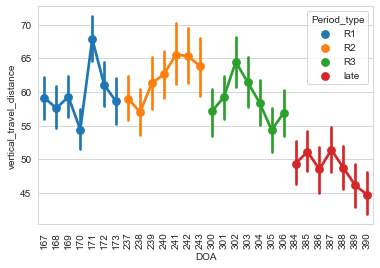

In [32]:
sns.pointplot(x='DOA', y='vertical_travel_distance', hue='Period_type', data=df_exp2);
plt.xticks(fontsize=10,rotation=90); 
plt.savefig(os.path.join(path_extracted_data,'visual','rowlongitudinalExp2_VTD.png'), bbox_inches='tight')

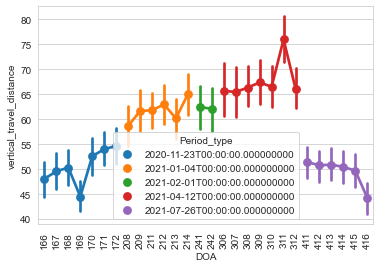

In [33]:
sns.pointplot(x='DOA',y='vertical_travel_distance',hue='Period_type', data=df_exp1);
plt.xticks(fontsize=10,rotation=90);
plt.savefig(os.path.join(path_extracted_data,'visual','rowlongitudinalExp1_VTD.png'), bbox_inches='tight')